In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from tqdm.notebook import trange, tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
%matplotlib notebook
device

/home/marco/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [2]:
train_dt = MNIST(
    root='./dataset',
    train=True,
    download=True,
    transform=ToTensor()
)

test_dt = MNIST(
    root='./dataset',
    train=False,
    download=True,
    transform=ToTensor()
)

/home/marco/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<IPython.core.display.Javascript object>


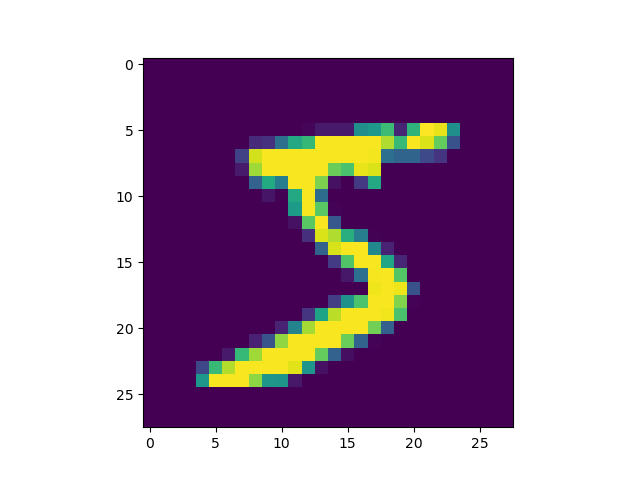

In [3]:
plt.imshow(train_dt[0][0].reshape(28, 28))

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.hidden_layers = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(256, 125),
            nn.LeakyReLU(),
            nn.Linear(125, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden_layers(x).reshape(-1, 1, 28, 28)
        return x

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 14, 5, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(14, 1, 5, padding=2),
            nn.LeakyReLU()
        )

        self.hidden_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(256, 125),
            nn.LeakyReLU(),
            nn.Linear(125, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.hidden_layers(x)

In [6]:
def get_noise(BS=1):
#     return torch.randn(BS, 100).to(device)
    return torch.randn(BS, 100, requires_grad=True).to(device)

<IPython.core.display.Javascript object>


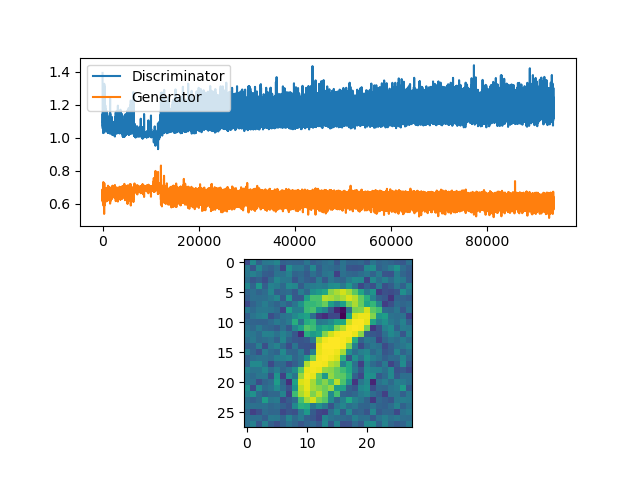

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
BS = 32
dtld = DataLoader(train_dt, batch_size=BS, num_workers=4)

D = Discriminator().to(device)
G = Generator().to(device)

d_optim = torch.optim.Adam(D.parameters(), lr=4e-4)
g_optim = torch.optim.Adam(G.parameters(), lr=1e-4)

loss_fn = nn.BCELoss()

epochs = 50

g_losses = []
d_losses = []

fig, (ax, img) = plt.subplots(2)

for epoch in (t:=trange(epochs)):
    ax.clear()

    for (X, _) in dtld:

        X = X.to(device).reshape(-1, 28, 28).requires_grad_()
        Z = get_noise(BS)

        # Predict
        real_out = D(X)
        fake_out = D(G(Z).detach())
        
        # Update discriminator
        loss_real_D=  loss_fn(real_out, torch.full_like(real_out, .9))
        loss_fake_D = loss_fn(fake_out, torch.zeros_like(fake_out))
        loss_D = loss_real_D + loss_fake_D

        loss_D.backward()
        d_optim.step()
        
        for p in D.parameters():
            p.grad = None
        d_losses.append(loss_D.item())
        
        # Update generator
        fake_out = D(G(Z))
        target = torch.full_like(fake_out, 1)

        loss_G = loss_fn(fake_out, target)
        loss_G.backward()
        g_optim.step()

        for p in G.parameters():
            p.grad = None
        g_losses.append(loss_G.item())

    ax.plot(d_losses, label='Discriminator')
    ax.plot(g_losses, label='Generator')
    ax.legend()
    img.imshow(G(get_noise()).detach().cpu().numpy().reshape(28,28))
    fig.canvas.draw()

<IPython.core.display.Javascript object>


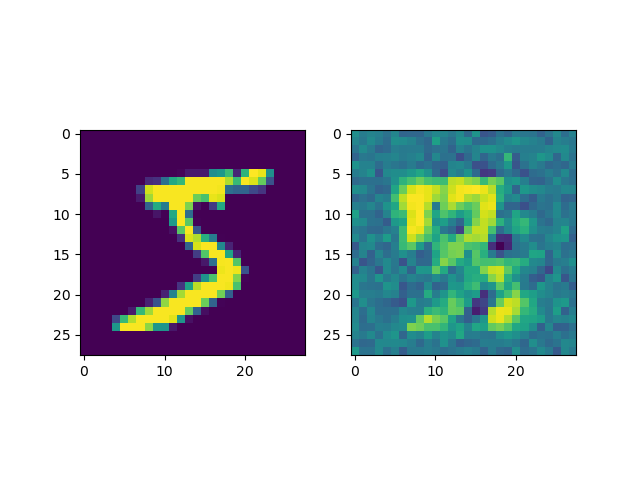

In [15]:
fig, axs = plt.subplots(1,2)
relu = nn.ReLU()

axs[0].imshow(train_dt[0][0].reshape(28,28))
with torch.set_grad_enabled(False):
    axs[1].imshow(G(get_noise()).cpu().numpy().reshape(28,28))